In [2]:
import os, sys

os.chdir(os.path.abspath("OptIForest"))
sys.path.append(os.getcwd())

print("Current working directory:", os.getcwd())
print("Contents:", os.listdir())


Current working directory: /Users/charuwin/OptIForest
Contents: ['test', '.ipynb_checkpoints', 'detectors', 'demo.py', 'data']


In [3]:
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

try:
    from detectors import OptIForest
except Exception as e:
    raise ImportError(
        "Couldn't import `OptIForest` from your repo. ".format(e)
    )


In [4]:
DATASET      = "ad"      
THRESHOLD    = 50       
BRANCH       = 3         
N_ENSEMBLERS = 100      # forest size
N_RUNS       = 5        

In [5]:
df = pd.read_csv(f"data/{DATASET}.csv", header=None)
X = df.values[:, :-1]
y = df.values[:, -1].astype(int)

print("Shape:", X.shape)
print("Label counts:", {int(k): int(v) for k,v in pd.Series(y).value_counts().sort_index().items()})
assert set(np.unique(y)).issubset({0,1}), "Labels must be 0/1 with 1=anomaly for metrics."


Shape: (3279, 1555)
Label counts: {0: 2820, 1: 459}


In [6]:
AUCs, APRs, Ttrain, Ttest = [], [], [], []


det = OptIForest('L2OPT', N_ENSEMBLERS, THRESHOLD, BRANCH)

for r in range(N_RUNS):
    t0 = time.time()
    det.fit(X)
    t_train = time.time() - t0

    scores = det.decision_function(X)   
    t_test = time.time() - t0 - t_train

    
    inv_scores = -scores

    auc  = roc_auc_score(y, inv_scores)
    ap   = average_precision_score(y, inv_scores)

    AUCs.append(auc); APRs.append(ap); Ttrain.append(t_train); Ttest.append(t_test)

print(f"AUC-ROC: {np.mean(AUCs):.3f} ± {np.std(AUCs):.3f}")
print(f"AUC-PR : {np.mean(APRs):.3f} ± {np.std(APRs):.3f}")
print(f"Train s: {np.mean(Ttrain):.3f} | Test s: {np.mean(Ttest):.3f}")


AUC-ROC: 0.764 ± 0.007
AUC-PR : 0.400 ± 0.036
Train s: 104.739 | Test s: 43.678


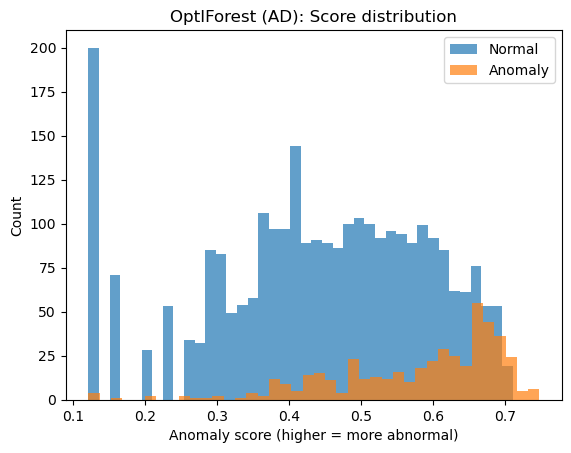

In [7]:

plt.figure()
plt.hist(inv_scores[y==0], bins=40, alpha=0.7, label="Normal")
plt.hist(inv_scores[y==1], bins=40, alpha=0.7, label="Anomaly")
plt.xlabel("Anomaly score (higher = more abnormal)")
plt.ylabel("Count")
plt.title("OptIForest (AD): Score distribution")
plt.legend()
plt.show()


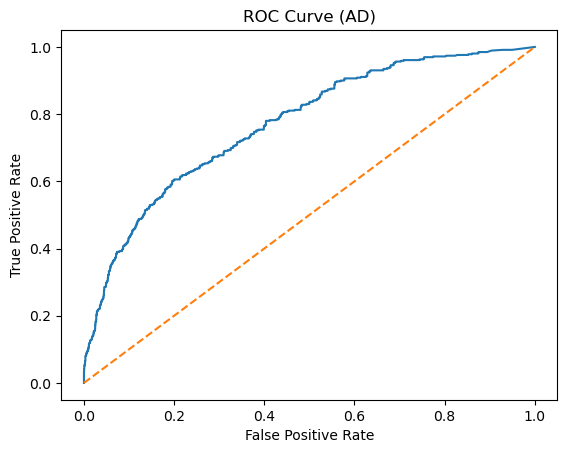

In [8]:
fpr, tpr, _ = roc_curve(y, inv_scores)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (AD)")
plt.show()


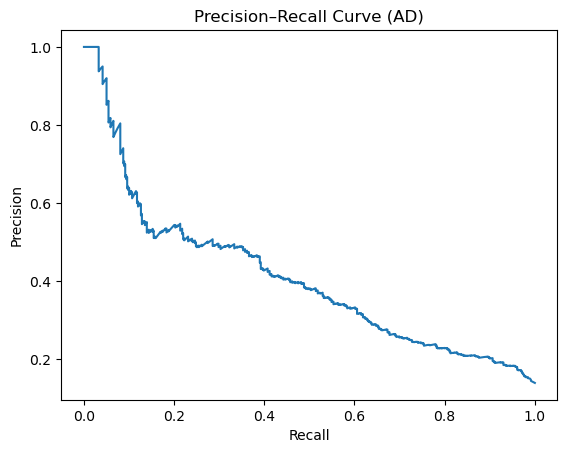

In [9]:
prec, rec, _ = precision_recall_curve(y, inv_scores)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (AD)")
plt.show()